In [32]:
import numpy as np
import pandas as pd

np.random.seed(23) 

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample,columns=['feature1','feature2','feature3'])
df['target'] = 1

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample,columns=['feature1','feature2','feature3'])

df1['target'] = 0

df = pd.concat([df, df1] ,ignore_index=True)

df = df.sample(40)

In [33]:
df.head()

,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


In [34]:
import plotly.express as px
#y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [35]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [36]:
# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [37]:
# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [38]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [39]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

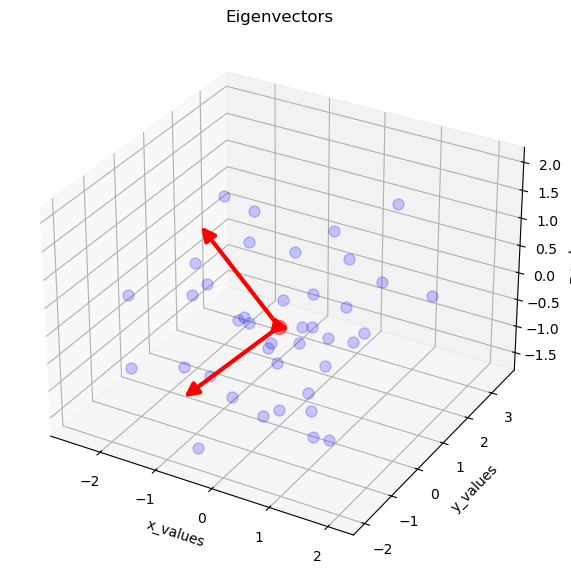

In [44]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import numpy as np

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
        self.axes = kwargs.get('axes', None)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        proj = self.axes.get_proj()
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, proj)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        proj = self.axes.get_proj()
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, proj)
        return np.min(zs)

# Plotting
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Your dataframe df and eigen_vectors should already be defined
ax.plot(df['feature1'], df['feature2'], df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)

# Mean point
mean_x = df['feature1'].mean()
mean_y = df['feature2'].mean()
mean_z = df['feature3'].mean()
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)

# Draw eigenvector arrows
for v in eigen_vectors.T:
    # Scale eigenvector direction for visibility
    scale = 2  # adjust as needed
    a = Arrow3D(
        [mean_x, mean_x + scale * v[0]],
        [mean_y, mean_y + scale * v[1]],
        [mean_z, mean_z + scale * v[2]],
        mutation_scale=20,
        lw=3,
        arrowstyle="-|>",
        color="r"
    )
    ax.add_artist(a)

ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')
plt.title('Eigenvectors')
plt.show()


In [41]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [42]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 - 3,2
new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.599433,1.795862,1
1,1.056919,-0.212737,0
2,-0.271876,0.498222,1
3,-0.621586,0.023110,1
4,1.567286,1.730967,1


In [43]:
new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()